### Sentiment Analysis of Yelp Reviews

**Motivation**  
Opinions or sentiments can be expressed on different entities, such as a cell phone, a digital camera, or a bank. Opinions can also be expressed on features or aspects of entities e.g. the screen of a cell phone, the service of a restaurant, or the picture quality of a camera.  
  
Opinion Mining helps business houses to understand what consumers are saying and reporting about their products. While a positive sentiment may not boost the sales very much but the impact of single negative review is much more and that can hurt the sales and revenue quite significantly. Manual investigation of each review is costly and sometimes consumers do not provide explicit ratings too. So, it is imperative that business houses would need an automated system to classify reviews as a positive or a negative review. The product management team can then take corrective actions based on the feedbacks and sentiment analysis.

**Dataset**  
The dataset for this project was chosen from the RecSys Challenge 2013: Yelp business rating prediction hosted by Kaggle in 2013 https://www.kaggle.com/c/yelp-recsys-2013/data

![alt text](images/yelp.png "Yelp Sentiment Analysis")

In [676]:
# TODO: Possible Other things to try
# 1. Food Recognition - Named Entity Recognition on Foods? Identify the food names - Is there any corpus I can refer? 
# e.g. http://www.yelp.com/menu/gary-danko-san-francisco/
# 2. Co-relation between reviews marked as cool, funny, positive, negative and the social perceptions of the review
#    a study from Yahoo labs
#       https://labs.yahoo.com/publications/6690/if-it-funny-it-mean-understanding-social-perceptions-yelp-online-reviews
#    They found two interesting things. First, reviews voted as useful and funny are associated with lower user ratings and 
#    relatively negative tone in the review text. Second, reviews voted as cool tend to have a relatively positive tone and 
#    higher ratings. How to implement that?
# 3. Incorporate spelling correction e.g. aaammmazz and amazing are same, zucchini zuccini zuchinni are same.
# 4. Instead of Counter of most common words use Most Common adjectives of +ve reviews and -ve reviews 
#     e.g. amazing, wonderful, excellent, horrible, terrible Shallow Parsing or Chunking use Regex adjective followed by noun
#     <JJ><*><NN> e.g.delicious sushi, we are interested in extracting the delicious word
# 5. Count of most common words in +ve reviews and -ve reviews - DONE
# 6. Use a better/custom stop words list - DONE

In [1]:
# numerical modules
import pandas as pd
import numpy as np
import scipy as sp

# machine learning modules
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# text processing modules
from textblob import TextBlob, Word

import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import heapq
from collections import Counter, OrderedDict

# wordcloud visualization
from wordcloud import WordCloud

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#mongodb
from pymongo import MongoClient
import simplejson

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999999;

<IPython.core.display.Javascript object>

## 1. Data Loading

### 1.1 Read the Yelp Restaurants Review Dataset

In [679]:
review_df = pd.read_csv('data/yelp_restaurants_reviews.csv', encoding='utf-8')

In [680]:
review_df.columns

Index([u'business_id', u'date', u'review_id', u'stars', u'text', u'type',
       u'user_id', u'cool', u'useful', u'funny'],
      dtype='object')

### 1.2 Drop unnecessary columns

In [681]:
# 'business_id', 'review_id', 'user_id', 'date', 'type', 'funny', 'cool', 'useful' columns are irrelevant for this notebook
review_df.drop(['business_id', 'user_id', 'date', 'type', 'funny', 'cool', 'useful'], axis=1, inplace=True)

In [682]:
review_df.head(5)

,review_id,stars,text
0,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...
1,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...
2,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...
3,m2CKSsepBCoRYWxiRUsxAg,4,"Quiessence is, simply put, beautiful. Full wi..."
4,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...


### 1.3 Keep only the highly positive and highly negative reviews

In [683]:
# Drop reviews with 3 stars rating, they are neutral reviews
review_df = review_df[(review_df['stars'] > 3) | (review_df['stars'] < 3)]

In [684]:
review_df['sentiment'] = review_df['stars'].apply(lambda x : 1 if x > 3 else 0)

## 2. Data Pre-processing

**Let's look at some highly positive reviews**

In [685]:
pos_reviews = review_df[review_df['stars'] > 3][['review_id', 'text', 'stars', 'sentiment']].head(10)
pos_reviews

,review_id,text,stars,sentiment
0,fWKvX83p0-ka4JS3dc6E5A,My wife took me here on my birthday for breakf...,5,1
1,IjZ33sJrzXqU-0X6U8NwyA,I have no idea why some people give bad review...,5,1
2,IESLBzqUCLdSzSqm0eCSxQ,love the gyro plate. Rice is so good and I als...,4,1
3,m2CKSsepBCoRYWxiRUsxAg,"Quiessence is, simply put, beautiful. Full wi...",4,1
4,riFQ3vxNpP4rWLk_CSri2A,Drop what you're doing and drive here. After I...,5,1
5,XtnfnYmnJYi71yIuGsXIUA,Definitely come for Happy hour! Prices are ama...,4,1
6,jJAIXA46pU1swYyRCdfXtQ,Nobuo shows his unique talents with everything...,5,1
7,3rPt0LxF7rgmEUrznoH22w,Wonderful Vietnamese sandwich shoppe. Their ba...,5,1
8,cGnKNX3I9rthE0-TH24-qA,They have a limited time thing going on right ...,5,1
9,pfUwBKYYmUXeiwrhDluQcw,I'm 2 weeks new to Phoenix. I looked up Irish ...,4,1


**Let's look at some highly negative reviews**

In [686]:
neg_reviews = review_df[review_df['stars'] < 3][['review_id', 'text', 'stars', 'sentiment']].head(10)
neg_reviews

,review_id,text,stars,sentiment
10,HvqmdqWcerVWO3Gs6zbrOw,Was it worth the 21$ for a salad and small piz...,2,0
21,S9OVpXat8k5YwWCn6FAgXg,Disgusting! Had a Groupon so my daughter and ...,1,0
24,ApKbwpYJdnhhgP4NbjQw2Q,"I've eaten here many times, but none as bad as...",1,0
40,VyX6x7wnThr9g9Z6VBDIgA,I have to add to Andrew's review.....\r\n\r\nI...,2,0
46,GXj4PNAi095-q9ynPYH3kg,Another night meeting friends here. I have to...,1,0
47,LN4l4wklQB0IVBjm-vq9TA,Not busy at all but took nearly 45 min to get ...,1,0
51,jNewOjPp56NMDrKlajrgFQ,"Yikes, reading other reviews I realize my bad ...",1,0
59,EUCqs_gfKZi1YoKVkWjSYw,"really, I can't believe this place has receive...",1,0
75,2dEtB3h8yZEONOmUJIUPZQ,This is my first time back in years. It will b...,2,0
77,_o_WRkKLk7NJeOO6NsOmMA,Unless you are a regular or look like your wal...,1,0


### 2.1 Text Analysis and Cleaning

### 2.1.1 Removing Carriage Return and Newline Characters

In [688]:
# print the first positive yelp review
a_review = pos_reviews[pos_reviews['review_id'] == 'fWKvX83p0-ka4JS3dc6E5A']['text']
a_review

0    My wife took me here on my birthday for breakf...
Name: text, dtype: object

In [689]:
a_review = a_review[0]
a_review

u'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\r\n\r\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\r\n\r\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\r\n\r\nAnyway, I can\'t wait to go back!'

**New lines Issue:** e.g. '\r\n\r\nAnyway,...' The text is interspered with \r and \n characters

In [690]:
class CarriageReturnReplacer(object):
    """ Replaces \r\n expressions in a text.
    >>> replacer = CarriageReturnReplacer()
    >>> replacer.replace("\r\n\r\nAnyway, I can\'t wait to go back!")
    'Anyway, I can\'t wait to go back!'
    """
    
    def replace(self, text):
        s = text
        s = s.replace('\r\n', ' ')
        s = s.replace('\n\n', ' ') 
        s = s.replace('\n', ' ')
        s = s.replace('\r', ' ') 
        return s

In [691]:
newline_replacer = CarriageReturnReplacer()

In [692]:
a_review = newline_replacer.replace(a_review)
a_review

u'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.  Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.  While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.  Anyway, I can\'t wait to go back!'

### 2.1.2 Removing Extra Spaces

**Extra spaces Issue:** e.g. 'and it was excellent.  The weather was perfect' The text is interspered with extra spaces.

In [693]:
import re
class ExtraSpacesReplacer(object):
    """ Replaces extra spaces in a text.
    >>> replacer = ExtraSpacesReplacer()
    >>> replacer.replace("and it was excellent.  The weather was perfect")
    'and it was excellent. The weather was perfect'
    """
    
    def replace(self, text):
        s = text
        s = re.sub('\s\s+', ' ', s)
        return s

In [694]:
spaces_replacer = ExtraSpacesReplacer()

In [695]:
a_review = spaces_replacer.replace(a_review)
a_review

u'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I\'ve ever had. I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I\'ve ever had. Anyway, I can\'t wait to go back!'

### 2.1.3 Removing Contractions

In [696]:
a_review

u'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I\'ve ever had. I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I\'ve ever had. Anyway, I can\'t wait to go back!'

**Contrations Issue:** e.g. 'I can\'t wait to go back!' The word **can't** is a contration. Similarly, there are many other contractions such as **won't, I'm, I'll I'd** etc.

In [697]:
# Codes taken from Python 3 Text Processing with NLTK 3 Cookbook - Jacob Perkins

##################################################
## Replacing Words Matching Regular Expressions ##
##################################################

replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'I\'m', 'I am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
]

In [698]:
class ContractionReplacer(object):
    """ Replaces regular expression in a text.
    >>> replacer = RegexpReplacer()
    >>> replacer.replace("can't is a contraction")
    'cannot is a contraction'
    >>> replacer.replace("I should've done that thing I didn't do")
    'I should have done that thing I did not do'
    """
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
    def replace(self, text):
        s = text

        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)

        return s

In [699]:
contraction_sentence = "I can't imagine that can't won't be a contraction. \
I'm damn confident that can't ain't going to escape my fix."

In [700]:
contraction_replacer = ContractionReplacer()
contraction_replacer.replace(contraction_sentence)

'I cannot imagine that cannot will not be a contraction. I am damn confident that cannot is not going to escape my fix.'

In [703]:
a_review = contraction_replacer.replace(a_review)
a_review

u'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I have ever had. I am pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I have ever had. Anyway, I cannot wait to go back!'

### 2.1.4 Removing Repeated Characters

In [704]:
amazing_reviews = review_df[review_df.text.str.find('AAAMMMAZZING') != -1]
amazing_reviews

,review_id,stars,text,sentiment
1006,Vnr2wuBXEjbLtfQT_XuDSQ,5,Awesome food anyone??? Go check out Modern Ste...,1


In [705]:
# print the first positive yelp review
a_review = amazing_reviews['text'][1006]
a_review

u'Awesome food anyone??? Go check out Modern Steak in Scottsdale, AZ.\r\nGorgeous dining room! Excellent service (with our server Gabe)! And the food was AAAMMMAZZING!\r\n\r\nIt\'s located at Fashion Mall, but it\'s NOT a "mall" restaurant. A MUST go!'

**Repeated Characters Issue:** e.g. 'AAAMMMAZZING!' characters are repeated because of over enthusiasm of the author  and cannot be corrected by dictionary

In [706]:
# Codes taken from Python 3 Text Processing with NLTK 3 Cookbook - Jacob Perkins

####################################
## Replacing Repeating Characters ##
####################################
from nltk.corpus import wordnet

class RepeatReplacer(object):
    """ Removes repeating characters until a valid word from disctionary is found.
    >>> replacer = RepeatReplacer()
    >>> replacer.replace('looooove')
    'love'
    >>> replacer.replace('oooooh')
    'ooh'
    >>> replacer.replace('goose')
    'goose'
    """
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word
        
        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word

In [707]:
repeat_replacer = RepeatReplacer()

In [708]:
repeat_replacer.replace('AAAMMMAZZING')

'AMAZING'

**AAAMMMAZZING! is now replaced by AMAZING!**

Some more examples of repeatition cancellation.

In [709]:
repeat_replacer.replace('excellent')

'excellent'

In [710]:
repeat_replacer.replace('oooooh')

'ooh'

In [711]:
repeat_replacer.replace('yuuummmmyy!!!')

'yumy!!!'

Bug in the implementation, yummy has repeatations and is a valid word as well but here u and m both repeated which causes the confusion.

In [712]:
repeat_replacer.replace('aaaaaalright')

'alright'

In [713]:
repeat_replacer.replace('ammmazzing')

'amazing'

In [714]:
# dinner is a valid word so there should be no replacement
repeat_replacer.replace('dinner')

'dinner'

### 2.1.5 Spelling Correction

Let's find a review which has the word 'accommodated' mispelled.

In [715]:
misspelled_reviews = review_df[review_df.text.str.find('accomodate') != -1]
misspelled_reviews

,review_id,stars,text,sentiment
536,soA1xb5ug18f0Mb_sDwaVQ,4,This was another stop on our pub crawl and I o...,1
1200,5WSHeWRxZ91ACTBwkkWZ5w,5,Absolutely loved this place! My fiance and I c...,1
1425,Ij3tYiITRFl6RyMT7lHvwQ,4,I had my rehersal dinner here for my wedding. ...,1
1730,OGliW0Iolmdz8B-uJrDbDw,4,"I cannot speak for the food, (though the menu ...",1
2153,TD0AUwaxILhgrK37MduxQg,2,We planned a happy hour here this past Fri nig...,0
2766,QoM1UkjYKq9U8c_4lCUKaA,4,By FAR one of my favorite places to have break...,1
4415,G_aqfhfRok1lmH4jLCfcZw,4,"As an Irish lass thru and thru, the promise of...",1
5152,5XTqH2H2bZE7dOSuDJiQ3A,4,Had lunch here with 6 coworkers and the server...,1
6763,8l0L53OVe6wu9EYUUpN16Q,5,Went here last night when on our last night st...,1


In [716]:
# print the first positive yelp review
a_review = misspelled_reviews['text'][5152]
a_review

u"Had lunch here with 6 coworkers and the server accomodated 5 seperate checks with no fuss. She quickly brought out two baskets of soft warm bread that looked handmade, along with pouring out balsamic vinegar and light olive oil for dipping.\r\n\r\nThe server described the day's special, but we all ended up ordering eight inch pizzas (a lunch only size.) I had bacon and chose to have it cooked in the optional brick oven for $1 extra (not sure why they offer it seperately, but exp. at other places made me like the way it cooks better than reg. oven.)\r\n\r\nIt wasn't much to go on, but the food was good, the service friendly and efficient, and the everything was clean and neat. Recommended if you're in the area."

In [717]:
# Codes taken from Python 3 Text Processing with NLTK 3 Cookbook - Jacob Perkins

import enchant
from nltk.metrics import edit_distance

class SpellingReplacer(object):
    def __init__(self, dict_name='en', max_dist=1):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = max_dist
    
    def replace(self, word):
        if self.spell_dict.check(word):
            return word
    
        suggestions = self.spell_dict.suggest(word)
    
        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return suggestions[0]
        else:
            return word

In [718]:
spell_replacer = SpellingReplacer()

In [719]:
word = spell_replacer.replace('accomodated')
word

'accommodated'

In [720]:
# the same review has the word separate misspelled
word = spell_replacer.replace('seperate')
word

'separate'

## 2.2 Applying Text Processors

Once we know all the errors we can now apply each cleaner one by one on the reviews.

In [550]:
review_df = pd.read_csv('data/yelp_restaurants_reviews.csv', encoding='utf-8')
# 'business_id', 'review_id', 'user_id', 'date', 'type', 'funny', 'cool', 'useful' columns are irrelevant for this notebook
review_df.drop(['business_id', 'user_id', 'date', 'type', 'funny', 'cool', 'useful'], axis=1, inplace=True)

In [551]:
# rep = 5XTqH2H2bZE7dOSuDJiQ3A, spell = Vnr2wuBXEjbLtfQT_XuDSQ, pos = fWKvX83p0-ka4JS3dc6E5A, neg = HvqmdqWcerVWO3Gs6zbrOw, 
# aspect +ve = hre97jjSwon4bn1muHKOJg, aspect -ve = HvqmdqWcerVWO3Gs6zbrOw
review_df = review_df[((review_df['review_id'] == '5XTqH2H2bZE7dOSuDJiQ3A') == True) |\
                      ((review_df['review_id'] == 'Vnr2wuBXEjbLtfQT_XuDSQ') == True) |\
                      ((review_df['review_id'] == 'fWKvX83p0-ka4JS3dc6E5A') == True) |\
                      ((review_df['review_id'] == 'HvqmdqWcerVWO3Gs6zbrOw') == True) |\
                      ((review_df['review_id'] == 'hre97jjSwon4bn1muHKOJg') == True)]

In [727]:
len(review_df[review_df['sentiment'] == 1])

4694

In [728]:
# replace new line characters
review_df['text'] = review_df['text'].apply(newline_replacer.replace)

In [729]:
# replace extra spaces
review_df['text'] = review_df['text'].apply(spaces_replacer.replace)

In [730]:
# replace contractions
review_df['text'] = review_df['text'].apply(contraction_replacer.replace)

In [731]:
# replace repeatitions
#review_df['text'] = review_df['text'].apply(repeat_replacer.replace)

In [732]:
a_review = review_df[review_df['review_id'] == 'fWKvX83p0-ka4JS3dc6E5A']['text']
a_review[0]

u'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I have ever had. I am pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I have ever had. Anyway, I cannot wait to go back!'

I reserved the Spell Checker and Repeat Characters replacers for now because they work well on individual tokens and will make sense when we tokenize the text.

In [8]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

In [734]:
def save_pandas_reviews_mongo(df, db='Yelp_Reviews_2', collection='Reviews', host='localhost', port=27017, username=None, password=None):
    """ Save into Mongo """
    
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].remove({})
    
    db[collection].insert_many(df.to_dict('records'))

    print 'Done Saving Sample Reviews.'

In [735]:
save_pandas_reviews_mongo(df=review_df, collection='Cleaned_Reviews')

Done Saving Sample Reviews.


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.


## 3 Parts Of Speech Tagging - Having Fun with WordCloud

In [736]:
def tagged_sents(document):    
    spell_replacer = SpellingReplacer()
    repeat_replacer = RepeatReplacer()
    
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    
    tagged_sentences = []
    for sent in sentences:
        corrected_words = []
        for word in sent:
            word = spell_replacer.replace(word)
            word = repeat_replacer.replace(word)
            corrected_words.append(word)
        tagged_sentences.append(corrected_words)
        
    tagged_sentences = [nltk.pos_tag(sent) for sent in tagged_sentences]
    return tagged_sentences

### 3.1 Parallelizing Pandas with MongoDB

In [743]:
def worker(identifier, start, end):
    
    db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='Yelp_Reviews_2')
    reviews_collection = db['Cleaned_Reviews']
    tags_collection = db['Cleaned_Tagged_Reviews']

    batch_size = 1
    for batch in range(start, end, batch_size):
        reviews_cursor = reviews_collection.find().skip(batch).limit(min(end - batch, batch_size))
        #print '\nWorker ' + str(identifier) + ': start = ' + str(start) + ', end = ' + str(end) + ', batch = ' + str(batch)
        for review in reviews_cursor:            
            
            try:
                tagged_sentences = tagged_sents(review["text"].lower())

                tags_collection.insert_one({
                                "review_id": review["review_id"],
                                "text": review["text"],
                                "stars": review["stars"],
                                "sentiment": review["sentiment"],
                                "tagged_sentences" : tagged_sentences
                            })
            except:
                print "Exception while tagging review: " + review["review_id"]
                print "Unexpected error:", sys.exc_info()[0]

    print 'Worker' + str(identifier) + ': Done '

In [744]:
import multiprocessing
import time
import sys

def process_job():
    db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='Yelp_Reviews_2')
    reviews_collection = db['Cleaned_Reviews']
    tags_collection = db['Cleaned_Tagged_Reviews']
    tags_collection.remove({})
    
    #reviews_cursor = reviews_collection.find()
    count = reviews_collection.count()
    workers = 4
    batch = count / workers
    left = count % workers

    jobs = []
    for i in range(workers):
        size = count / workers
        if i == (workers - 1):
            size += left
        p = multiprocessing.Process(target=worker, args=((i + 1), i * batch, i * batch + size))
        jobs.append(p)
        p.start()

    for j in jobs:
        j.join()
        print '%s.exitcode = %s' % (j.name, j.exitcode)

In [745]:
process_job()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.


Process-23.exitcode = 0
Process-24.exitcode = 0Exception while tagging review: Y0MSBSg8AqpzLobWC8aTKQ
Exception while tagging review: fwdbRIFrGS0jQT4GbiDTjA
Worker1: Done 
Unexpected error: <class 'nltk.corpus.reader.wordnet.WordNetError'>
Unexpected error: <class 'nltk.corpus.reader.wordnet.WordNetError'>
Worker2: Done 

Process-25.exitcode = 0Worker3: Done 

Process-26.exitcode = 0Worker4: Done 



In [5]:
def read_reviews_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [6]:
'''mongodb saves tagged sentences in [[[word, tag], [word, tag]]] format, we need to 
reconstruct intob[[(word, tag), (word, tag)]] format for nltk subsequent APIs to work
'''
def convert_to_nltk_tagged_sentences(tagged_sentences):
    sentences = []
    for tagged_sentence in tagged_sentences:
        sentence = []
        for [word, tag] in tagged_sentence:
            #print (word, tag)
            sentence.append((word, tag))
        sentences.append(sentence)
    #print sentences
    return sentences

In [9]:
review_df = read_reviews_mongo(db='Yelp_Reviews_2', collection='Cleaned_Tagged_Reviews', no_id=True)
review_df.head(5)

,review_id,sentiment,stars,tagged_sentences,text
0,VKX0dQue8PQqNa2dMR4C_Q,0,1,"[[[closed, VBN], [on, IN], [Sunday, NNP], [e, ...",Closed on Sunday? Looks like you have not only...
1,6EDCixSnNJCoKqhjp1p8lw,1,4,"[[[this, DT], [place, NN], [has, VBZ], [great,...","This place has great food - some of the best ""..."
2,FyZfuAb5dcou0g6f_S9pQQ,1,4,"[[[pop eyes, NNS], [yes, NNS], [that, WDT], [i...","Popeyes yes that is right Popeyes, after recen..."
3,fWKvX83p0-ka4JS3dc6E5A,1,5,"[[[my, PRP$], [wife, NN], [took, VBD], [me, PR...",My wife took me here on my birthday for breakf...
4,lc_GXewm6m5H4pIKmI8-ng,1,4,"[[[the, DT], [lodge, NN], [has, VBZ], [been, V...",The Lodge has been a pretty consistent happy h...


In [10]:
review_df['tagged_sentences'] = review_df['tagged_sentences'].apply(convert_to_nltk_tagged_sentences)
review_df.head(5)

,review_id,sentiment,stars,tagged_sentences,text
0,VKX0dQue8PQqNa2dMR4C_Q,0,1,"[[(closed, VBN), (on, IN), (Sunday, NNP), (e, ...",Closed on Sunday? Looks like you have not only...
1,6EDCixSnNJCoKqhjp1p8lw,1,4,"[[(this, DT), (place, NN), (has, VBZ), (great,...","This place has great food - some of the best ""..."
2,FyZfuAb5dcou0g6f_S9pQQ,1,4,"[[(pop eyes, NNS), (yes, NNS), (that, WDT), (i...","Popeyes yes that is right Popeyes, after recen..."
3,fWKvX83p0-ka4JS3dc6E5A,1,5,"[[(my, PRP$), (wife, NN), (took, VBD), (me, PR...",My wife took me here on my birthday for breakf...
4,lc_GXewm6m5H4pIKmI8-ng,1,4,"[[(the, DT), (lodge, NN), (has, VBZ), (been, V...",The Lodge has been a pretty consistent happy h...


### 3.2 Extract only Adjectives from the reviews

In [11]:
def tagged_adjectives(tagged_sentences):
    adjectives = []
    for sentence in tagged_sentences:
        for (word, tag) in sentence:
            if tag.find('JJ') != -1:
                adjectives.append(word)
    return adjectives

In [12]:
review_df['adjectives'] = review_df['tagged_sentences'].apply(tagged_adjectives)

### 3.3 Popular Adjectives most used in Positive Reviews

In [13]:
all_positive_adjectives = review_df[review_df['stars'] > 3]['adjectives'].tolist()
all_positive_adjectives = [item for sublist in all_positive_adjectives for item in sublist if len(item) > 2]

In [14]:
# Find word count
counter = Counter()
for word in all_positive_adjectives:
    counter[word] += 1
print counter.most_common(20)

[(u'good', 3702), (u'great', 3039), (u'best', 1124), (u'little', 1083), (u'delicious', 1049), (u'nice', 982), (u'other', 877), (u'fresh', 802), (u'happy', 683), (u'more', 625), (u'friendly', 610), (u'few', 570), (u'first', 555), (u'tasty', 525), (u'favorite', 507), (u'sure', 491), (u'excellent', 485), (u'hot', 483), (u'next', 475), (u'awesome', 466)]


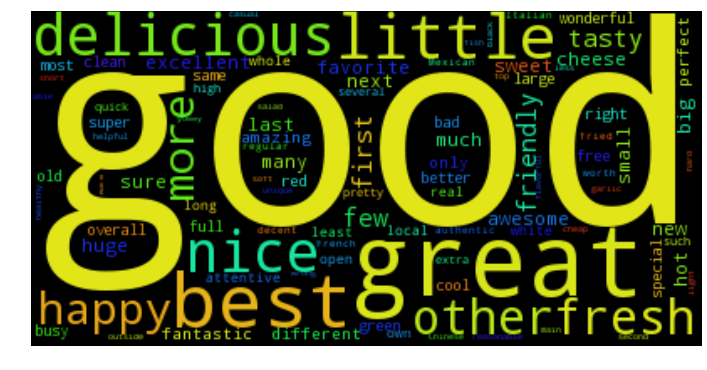

In [15]:
# Wordcloud of top 100 adjectives for positive reviews
plt.figure(figsize=(12,12))
wordcloud = WordCloud().fit_words(counter.most_common(100))
plt.axis("off")
plt.imshow(wordcloud)

### 3.3 Popular Adjectives most used in Negative Reviews

In [16]:
all_negative_adjectives = review_df[review_df['stars'] < 3]['adjectives'].tolist()
all_negative_adjectives = [item for sublist in all_negative_adjectives for item in sublist if len(item) > 2]

In [17]:
# Find word count
counter = Counter()
for word in all_negative_adjectives:
    counter[word] += 1
print counter.most_common(20)

[(u'good', 748), (u'other', 314), (u'bad', 261), (u'great', 254), (u'more', 199), (u'much', 196), (u'better', 190), (u'few', 180), (u'little', 173), (u'nice', 170), (u'first', 169), (u'last', 157), (u'best', 148), (u'new', 140), (u'many', 138), (u'next', 130), (u'same', 122), (u'only', 119), (u'small', 112), (u'least', 106)]


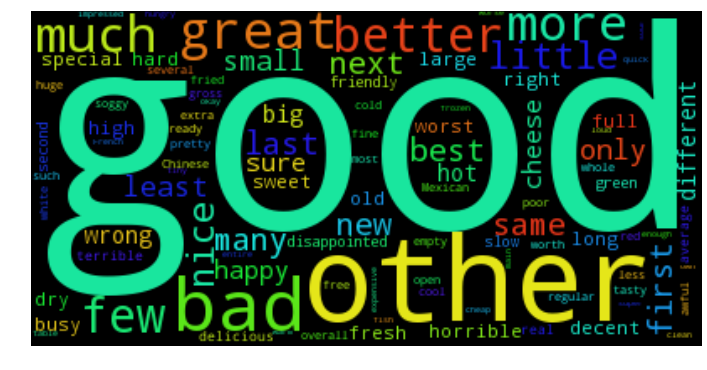

In [18]:
# Wordcloud of top 100 adjectives for positive reviews
plt.figure(figsize=(12,12))
wordcloud = WordCloud().fit_words(counter.most_common(100))
plt.axis("off")
plt.imshow(wordcloud)

### 4 Chunking Phrases : Aspect Mining

Finding adjective + noun phrases that co-occur in the same sentence, not necessarily contiguous; for example "big_screen", "bad_food". Combination instead of just adjectives can convey different sentiment depending on context e.g big_screen is good for TVs but bad for cellphones.

This was suggested by my mentor **Sujit Paul - Technology Research Director at Elsevier Labs**  
https://www.linkedin.com/in/sujitpal

Here we use NLTK's Regex based Parts of Speech Chunking to identify co-located pairs of words either adjective_noun or noun+adjective

In [19]:
from nltk.chunk import RegexpParser
def get_chunks(tagged_sentences):
    grammar = r"""
    CHUNK1:
        {<NN.*><.*>?<JJ.*>}  # Any Noun terminated with Any Adjective
    
    CHUNK2:
        {<NN.*|JJ.*><.*>?<NN.*>}  # Nouns or Adjectives, terminated with Nouns
    """
    cp = RegexpParser(grammar)
    for sent in tagged_sentences:
        tree = cp.parse(sent)
        for subtree in tree.subtrees(filter = lambda t: t.label() in ['CHUNK1', 'CHUNK2']):
            print(subtree)
            words = [word for word, tag in subtree.leaves() if tag in ['JJ', 'NN', 'NNS']]
            print words

In [20]:
positive_reviews = review_df[review_df['review_id'] == 'hre97jjSwon4bn1muHKOJg']
positive_reviews

,review_id,sentiment,stars,tagged_sentences,text,adjectives
74,hre97jjSwon4bn1muHKOJg,1,4,"[[(always, RB), (reliably, RB), (good, JJ), (....",Always reliably good. Great beer selection as ...,"[good, great, fabulous, outstanding, healthy, ..."


In [21]:
a_positive_review = positive_reviews['text'][74]
a_positive_review

u'Always reliably good. Great beer selection as well as fabulous "bitch fizz" (ciders, etc.) and cocktails. Their pizza is outstanding AND they have a healthy menu. I generally steer clear of chains but this is an exception.'

In [22]:
print positive_reviews['tagged_sentences'][74]

[[(u'always', u'RB'), (u'reliably', u'RB'), (u'good', u'JJ'), (u'.', u'.')], [(u'great', u'JJ'), (u'beer', u'NN'), (u'selection', u'NN'), (u'as', u'RB'), (u'well', u'RB'), (u'as', u'IN'), (u'fabulous', u'JJ'), (u'``', u'``'), (u'bitch', u'NN'), (u'fizz', u'NN'), (u"''", u"''"), (u'e', u'NN'), (u'ciders', u'NNS'), (u'e', u'VBP'), (u'etc', u'FW'), (u'.', u'.'), (u'e', u'NN')], [(u'and', u'CC'), (u'cocktails', u'NNS'), (u'.', u'.')], [(u'their', u'PRP$'), (u'pizza', u'NN'), (u'is', u'VBZ'), (u'outstanding', u'JJ'), (u'and', u'CC'), (u'they', u'PRP'), (u'have', u'VBP'), (u'a', u'DT'), (u'healthy', u'JJ'), (u'menu', u'NN'), (u'.', u'.')], [(u'i', u'NN'), (u'generally', u'RB'), (u'steer', u'VBD'), (u'clear', u'JJ'), (u'of', u'IN'), (u'chains', u'NNS'), (u'but', u'CC'), (u'this', u'DT'), (u'is', u'VBZ'), (u'an', u'DT'), (u'exception', u'NN'), (u'.', u'.')]]


In [23]:
get_chunks(positive_reviews['tagged_sentences'][74])

(CHUNK2 great/JJ beer/NN selection/NN)
[u'great', u'beer', u'selection']
(CHUNK2 fabulous/JJ ``/`` bitch/NN)
[u'fabulous', u'bitch']
(CHUNK2 fizz/NN ''/'' e/NN)
[u'fizz', u'e']
(CHUNK1 pizza/NN is/VBZ outstanding/JJ)
[u'pizza', u'outstanding']
(CHUNK2 healthy/JJ menu/NN)
[u'healthy', u'menu']
(CHUNK2 clear/JJ of/IN chains/NNS)
[u'clear', u'chains']


**notable positive aspect phrases**  
great beer selection  
outstanding pizza  
healthy menu

In [24]:
negative_reviews = review_df[review_df['review_id'] == 'HvqmdqWcerVWO3Gs6zbrOw']
negative_reviews

,review_id,sentiment,stars,tagged_sentences,text,adjectives
55,HvqmdqWcerVWO3Gs6zbrOw,0,2,"[[(was, VBD), (it, PRP), (worth, IN), (the, DT...",Was it worth the 21$ for a salad and small piz...,"[small, bad, small, less, mm, x, large, large,..."


In [25]:
a_negative_review = negative_reviews['text'][55]
a_negative_review

u'Was it worth the 21$ for a salad and small pizza? Absolutely not! Bad service. Maybe the guys grandma died I do not know. I want to tell you what really made me mad about the experience. We order the small pizza and salad and the guys could have cared less and took our $ and we sat down. We were looking around and hmm, there is a sign saying "x large pizza and large salad only 23$". Wow that would have been nice if the guy told us that. I left hungry, mad and unsatisfied. To the owner: teach your employees the value of upselling and telling the specials. Something so small can affect a customers experience negatively. And your salads are severely overpriced Wo not go back unless I am desperate.'

In [26]:
print negative_reviews['tagged_sentences'][55]

[[(u'was', u'VBD'), (u'it', u'PRP'), (u'worth', u'IN'), (u'the', u'DT'), (u'21', u'CD'), (u'e', u'NN'), (u'for', u'IN'), (u'a', u'DT'), (u'salad', u'NN'), (u'and', u'CC'), (u'small', u'JJ'), (u'pizza', u'NN'), (u'e', u'NN')], [(u'absolutely', u'RB'), (u'not', u'RB'), (u'e', u'VB')], [(u'bad', u'JJ'), (u'service', u'NN'), (u'.', u'.')], [(u'maybe', u'RB'), (u'the', u'DT'), (u'guys', u'NNS'), (u'grandma', u'VBP'), (u'died', u'VBD'), (u'i', u'NNS'), (u'do', u'VBP'), (u'not', u'RB'), (u'know', u'VB'), (u'.', u'.')], [(u'i', u'NN'), (u'want', u'VBP'), (u'to', u'TO'), (u'tell', u'VB'), (u'you', u'PRP'), (u'what', u'WDT'), (u'really', u'RB'), (u'made', u'VBD'), (u'me', u'PRP'), (u'mad', u'VB'), (u'about', u'IN'), (u'the', u'DT'), (u'experience', u'NN'), (u'.', u'.')], [(u'we', u'PRP'), (u'order', u'NN'), (u'the', u'DT'), (u'small', u'JJ'), (u'pizza', u'NN'), (u'and', u'CC'), (u'salad', u'NN'), (u'and', u'CC'), (u'the', u'DT'), (u'guys', u'NNS'), (u'could', u'MD'), (u'have', u'VB'), (u'cared',

In [27]:
get_chunks(negative_reviews['tagged_sentences'][55])

(CHUNK1 salad/NN and/CC small/JJ)
[u'salad', u'small']
(CHUNK2 pizza/NN e/NN)
[u'pizza', u'e']
(CHUNK2 bad/JJ service/NN)
[u'bad', u'service']
(CHUNK1 order/NN the/DT small/JJ)
[u'order', u'small']
(CHUNK2 pizza/NN and/CC salad/NN)
[u'pizza', u'salad']
(CHUNK2 mm/JJ e/NN)
[u'mm', u'e']
(CHUNK2 large/JJ (CHUNK1 pizza/NN and/CC large/JJ) salad/NN)
[u'large', u'pizza', u'large', u'salad']
(CHUNK1 pizza/NN and/CC large/JJ)
[u'pizza', u'large']
(CHUNK1 i/NN left/VBD hungry/JJ)
[u'i', u'hungry']
(CHUNK1 mad/NN and/CC unsatisfied/JJ)
[u'mad', u'unsatisfied']
(CHUNK1 value/NN of/IN upweling/JJ)
[u'value', u'upweling']
(CHUNK1 something/NN so/RB small/JJ)
[u'something', u'small']
(CHUNK2 customers/NNS experience/NN)
[u'customers', u'experience']
(CHUNK2 unles/JJ i/NN)
[u'unles', u'i']


**notable negative aspect phrases**  
bad service  
hungry  
mad unsatisfied

## 5. Sentiment Classification with Logistic Regression

### 5.1 Bag Of Words Model

Here we will be using here is called a **bag-of-words** model. In this kind of model we simplify documents to a multi-set of terms frequencies. That means that, for our model, a document sentiment tag will depend on what words appear in that document, discarding any grammar or word order but keeping multiplicity.

#### 5.1.1 Counting Word Frequency

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

english_stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def dictionary_from_tagged_sentences(tagged_sentences):
    counter = Counter()
    for tagged_sentence in tagged_sentences:
        tokens = [] # word.strip().lower()
        tokens = [re.sub("[^a-zA-Z]", "", word) for (word, tag) in tagged_sentence]
        tokens = [elem.strip().lower() for elem in tokens]
        tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
        tokens = [lemmatizer.lemmatize(elem) for elem in tokens]
        for token in tokens:
            counter[token] += 1
    return counter

In [29]:
review_df['word_counts'] = review_df['tagged_sentences'].apply(dictionary_from_tagged_sentences)
review_df.head(5)

,review_id,sentiment,stars,tagged_sentences,text,adjectives,word_counts
0,VKX0dQue8PQqNa2dMR4C_Q,0,1,"[[(closed, VBN), (on, IN), (Sunday, NNP), (e, ...",Closed on Sunday? Looks like you have not only...,[],"{u'look': 1, u'lost': 1, u'dollar': 1, u'busin..."
1,6EDCixSnNJCoKqhjp1p8lw,1,4,"[[(this, DT), (place, NN), (has, VBZ), (great,...","This place has great food - some of the best ""...","[great, best, big, reasonable, happy, regular,...","{u'right': 1, u'taste': 1, u'one': 1, u'drinke..."
2,FyZfuAb5dcou0g6f_S9pQQ,1,4,"[[(pop eyes, NNS), (yes, NNS), (that, WDT), (i...","Popeyes yes that is right Popeyes, after recen...","[right, pretty, e, uncle, sure, local, many, c...","{u'right': 1, u'thigh': 1, u'deal': 1, u'tuesd..."
3,fWKvX83p0-ka4JS3dc6E5A,1,5,"[[(my, PRP$), (wife, NN), (took, VBD), (me, PR...",My wife took me here on my birthday for breakf...,"[excellent, perfect, absolute, excellent, semi...","{u'griddled': 1, u'bread': 1, u'meal': 1, u'an..."
4,lc_GXewm6m5H4pIKmI8-ng,1,4,"[[(the, DT), (lodge, NN), (has, VBZ), (been, V...",The Lodge has been a pretty consistent happy h...,"[consistent, happy, last, great, cheese, great...","{u'cheese': 2, u'love': 1, u'miller': 1, u'con..."


### 5.2 Logistic Regression with Engineered Features

In [30]:
from sklearn.feature_extraction import DictVectorizer

dict_vect = DictVectorizer()
review_dict_tf = dict_vect.fit_transform(review_df['word_counts'])

In [31]:
# Numpy arrays are easy to work with, so convert the result to an array
review_dict_tf_nd = review_dict_tf.toarray()
review_dict_tf_nd.shape

(5849, 18804)

In [32]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_dict_tf_nd, columns=dict_vect.get_feature_names())
df.head(5)

,aah,aaron,aarp,aback,abandon,abandoned,abaye,abbreviated,abbreviation,abc,...,zooming,zteas,ztejas,ztrip,zucchini,zuchini,zuchinimushrom,zupas,zuzu,zweigel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = dict_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

[u'aah', u'aaron', u'aarp', u'aback', u'abandon', u'abandoned', u'abaye', u'abbreviated', u'abbreviation', u'abc', u'abdab', u'abe', u'aberration', u'ability', u'able', u'abnormally', u'abodoba', u'abogado', u'abound', u'abrasive', u'abridged', u'abroad', u'abrupt', u'abruptly', u'absence', u'absent', u'absolute', u'absolutely', u'absolutley', u'absorb', u'absorbed', u'absorption', u'abstained', u'abstract', u'absurd', u'absurdly', u'abuelita', u'abuelo', u'abuelos', u'abundance', u'abundant', u'abuse', u'abused', u'aby', u'abysmal', u'acacia', u'academia', u'acai', u'acapulco', u'accent', u'accented', u'accept', u'acceptable', u'accepted', u'accepting', u'accepts', u'access', u'accessed', u'accessible', u'accessory', u'accident', u'accidental', u'accidentally', u'acclaimed', u'acclimated', u'accolade', u'accommodate', u'accommodated', u'accommodates', u'accommodating', u'accommodation', u'accompanied', u'accompanies', u'accompaniment', u'accompany', u'accompanying', u'accomplish', u'a

In [39]:
# split Train and Validation Data Set, stratified sampling
X_train, X_test, y_train, y_test  = train_test_split(review_dict_tf_nd, review_df['sentiment'], train_size=0.75, stratify=review_df['sentiment'])

In [40]:
# Create and train the Logistic Regression Classifier
log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train, y=y_train)

In [41]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tf_model.predict(X=X_test)
y_pred_proba = log_tf_model.predict_proba(X=X_test)[:,1]

In [42]:
#calculates several types of (predictive) scores on a classification model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.66      0.73       289
          1       0.92      0.96      0.94      1174

avg / total       0.90      0.90      0.90      1463



In [43]:
print("accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

accuracy: 0.904990


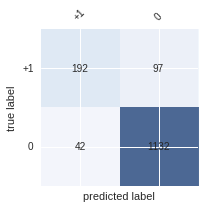

In [44]:
from pylab import rcParams
labels = ['+1', '0']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

### 5.3 Logistic Regression without any feature engineering

In [45]:
import re
def lemma_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # lemmas
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
        
    return lemmas

In [46]:
count_vect = CountVectorizer(analyzer = 'word', tokenizer=lemma_tokenizer, token_pattern=None, lowercase=True)
review_count_tf = count_vect.fit_transform(review_df['text'].tolist())

In [47]:
# Numpy arrays are easy to work with, so convert the result to an array
review_count_tf_nd = review_count_tf.toarray()
review_count_tf_nd.shape

(5849, 18071)

In [48]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_count_tf_nd, columns=count_vect.get_feature_names())
df.head(5)

,aaaamazing,aaammmazzing,aah,aaron,aarp,aback,abandon,abandoned,abbaye,abbreviated,...,zucca,zucchini,zuccini,zuchinni,zuma,zupas,zur,zuzu,zweigel,zzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = count_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

[u'aaaamazing', u'aaammmazzing', u'aah', u'aaron', u'aarp', u'aback', u'abandon', u'abandoned', u'abbaye', u'abbreviated', u'abbreviation', u'abby', u'abc', u'abe', u'aberration', u'ability', u'able', u'abnormally', u'abodoba', u'abogado', u'abou', u'abound', u'abrasive', u'abridged', u'abroad', u'abrupt', u'abruptly', u'absence', u'absense', u'absent', u'absolut', u'absolute', u'absolutely', u'absolutley', u'absolutly', u'absorb', u'absorbed', u'absorption', u'abstained', u'abstract', u'absurd', u'absurdly', u'abuelita', u'abuelo', u'abuelos', u'abundance', u'abundant', u'abuse', u'abused', u'abysmal', u'acacia', u'academie', u'acai', u'acapulco', u'accent', u'accented', u'accept', u'acceptable', u'accepted', u'accepting', u'accepts', u'access', u'accessed', u'accessible', u'accessibly', u'accessorize', u'accessory', u'accident', u'accidental', u'accidentally', u'accidently', u'acclaimed', u'acclimated', u'accolade', u'accommodate', u'accommodated', u'accommodates', u'accommodating', 

In [52]:
# split Train and Validation Data Set, stratified sampling
X_train, X_test, y_train, y_test  = train_test_split(review_count_tf_nd, review_df['sentiment'], train_size=0.75, stratify=review_df['sentiment'])

In [53]:
# Create and train the Logistic Regression Classifier
log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train, y=y_train)

In [54]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tf_model.predict(X=X_test)
y_pred_proba = log_tf_model.predict_proba(X=X_test)[:,1]

In [55]:
#calculates several types of (predictive) scores on a classification model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.73      0.76       289
          1       0.93      0.95      0.94      1174

avg / total       0.91      0.91      0.91      1463



In [56]:
print("accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

accuracy: 0.907724


### 5.4 Conclusion

With Feature Engineering accuracy is 0.901572. Without Feature Engineering accuracy is 0.912509. I was expecting significant improvement in accuracy with word cleanup but I did not get that :-(

## 6 Topic Modelling - gensim LDA

In [57]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

english_stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def tagged_nouns(tagged_sentences):
    nouns = []
    for tagged_sentence in tagged_sentences:
        for (word, tag) in tagged_sentence:
            if word not in english_stops and len(word) > 2 and tag.find('NN') != -1:
                nouns.append(lemmatizer.lemmatize(word))
                
    return nouns

In [58]:
review_df['nouns'] = review_df['tagged_sentences'].apply(tagged_nouns)

In [59]:
review_df.head(5)

,review_id,sentiment,stars,tagged_sentences,text,adjectives,word_counts,nouns
0,VKX0dQue8PQqNa2dMR4C_Q,0,1,"[[(closed, VBN), (on, IN), (Sunday, NNP), (e, ...",Closed on Sunday? Looks like you have not only...,[],"{u'look': 1, u'lost': 1, u'dollar': 1, u'busin...","[Sunday, look, Sunday, dollar, business, Monda..."
1,6EDCixSnNJCoKqhjp1p8lw,1,4,"[[(this, DT), (place, NN), (has, VBZ), (great,...","This place has great food - some of the best ""...","[great, best, big, reasonable, happy, regular,...","{u'right': 1, u'taste': 1, u'one': 1, u'drinke...","[place, food, bar, food, beer, brewery, beer, ..."
2,FyZfuAb5dcou0g6f_S9pQQ,1,4,"[[(pop eyes, NNS), (yes, NNS), (that, WDT), (i...","Popeyes yes that is right Popeyes, after recen...","[right, pretty, e, uncle, sure, local, many, c...","{u'right': 1, u'thigh': 1, u'deal': 1, u'tuesd...","[pop eyes, yes, pop eyes, Chicago, chicken, Po..."
3,fWKvX83p0-ka4JS3dc6E5A,1,5,"[[(my, PRP$), (wife, NN), (took, VBD), (me, PR...",My wife took me here on my birthday for breakf...,"[excellent, perfect, absolute, excellent, semi...","{u'griddled': 1, u'bread': 1, u'meal': 1, u'an...","[wife, birthday, breakfast, weather, ground, p..."
4,lc_GXewm6m5H4pIKmI8-ng,1,4,"[[(the, DT), (lodge, NN), (has, VBZ), (been, V...",The Lodge has been a pretty consistent happy h...,"[consistent, happy, last, great, cheese, great...","{u'cheese': 2, u'love': 1, u'miller': 1, u'con...","[lodge, hour, spot, year, half, food, drink, s..."


In [60]:
from gensim.models import LdaModel
from gensim import corpora
from pprint import pprint

In [61]:
documents = review_df['nouns'].tolist()

In [62]:
dictionary = corpora.Dictionary(documents)
#dictionary.filter_extremes(keep_n=10000)
#dictionary.compactify()
dictionary.save("model/dictionary.dict")

In [63]:
corpus = [dictionary.doc2bow(doc) for doc in documents]
corpora.MmCorpus.serialize('model/corpus.mm', corpus) # store to disk, for later use
#print(corpus)

In [64]:
dictionary = corpora.Dictionary.load('model/dictionary.dict')
corpus = corpora.MmCorpus('model/corpus.mm')

In [65]:
NUM_TOPICS = 12

In [66]:
model = LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)
model.save("model/lda_model_topics.lda")
print model

LdaModel(num_terms=11836, num_topics=12, decay=0.5, chunksize=2000)


In [67]:
model = LdaModel.load("model/lda_model_topics.lda")

for i, topic in enumerate(model.show_topics(num_topics=NUM_TOPICS)):
    print '#' + str(i) + ': ' + topic

#0: 0.040*place + 0.026*burger + 0.026*food + 0.020*pizza + 0.017*time + 0.013*service + 0.013*fry + 0.008*star + 0.007*sandwich + 0.007*price
#1: 0.016*food + 0.013*place + 0.013*restaurant + 0.012*breakfast + 0.009*beef + 0.009*bowl + 0.008*pho + 0.008*way + 0.008*sauce + 0.008*rice
#2: 0.028*place + 0.017*bar + 0.015*food + 0.013*restaurant + 0.013*wine + 0.011*menu + 0.010*service + 0.010*time + 0.009*night + 0.007*sandwich
#3: 0.032*pizza + 0.031*food + 0.017*beer + 0.013*service + 0.013*wing + 0.013*friend + 0.012*time + 0.011*order + 0.011*place + 0.008*lot
#4: 0.041*place + 0.029*food + 0.020*time + 0.012*menu + 0.011*service + 0.011*restaurant + 0.011*order + 0.010*chicken + 0.008*beer + 0.007*dinner
#5: 0.027*place + 0.018*food + 0.015*time + 0.012*thing + 0.010*service + 0.010*menu + 0.009*order + 0.009*pizza + 0.008*lunch + 0.008*sauce
#6: 0.028*place + 0.022*sushi + 0.019*roll + 0.015*food + 0.011*service + 0.009*time + 0.009*restaurant + 0.009*menu + 0.008*night + 0.008*b

In [68]:
model.show_topic(1, topn=10)

[(0.015556001229155474, u'food'),
 (0.013153456894664437, u'place'),
 (0.012833317965192855, u'restaurant'),
 (0.01190651534455537, u'breakfast'),
 (0.0085872210864522628, u'beef'),
 (0.0085387811448814563, u'bowl'),
 (0.008452951298562883, u'pho'),
 (0.0080359477525862415, u'way'),
 (0.0080191354362714479, u'sauce'),
 (0.0079352390845633027, u'rice')]

### 6.1 Word Cloud Visualisation of Topic Words

Original Author **Sujit Paul - Technology Research Director at Elsevier Labs**  
https://www.linkedin.com/in/sujitpal
http://sujitpal.blogspot.com/2015/07/using-keyword-generation-to-refine.html  
http://sujitpal.blogspot.com/2015/07/using-keyword-generation-to-refine.html

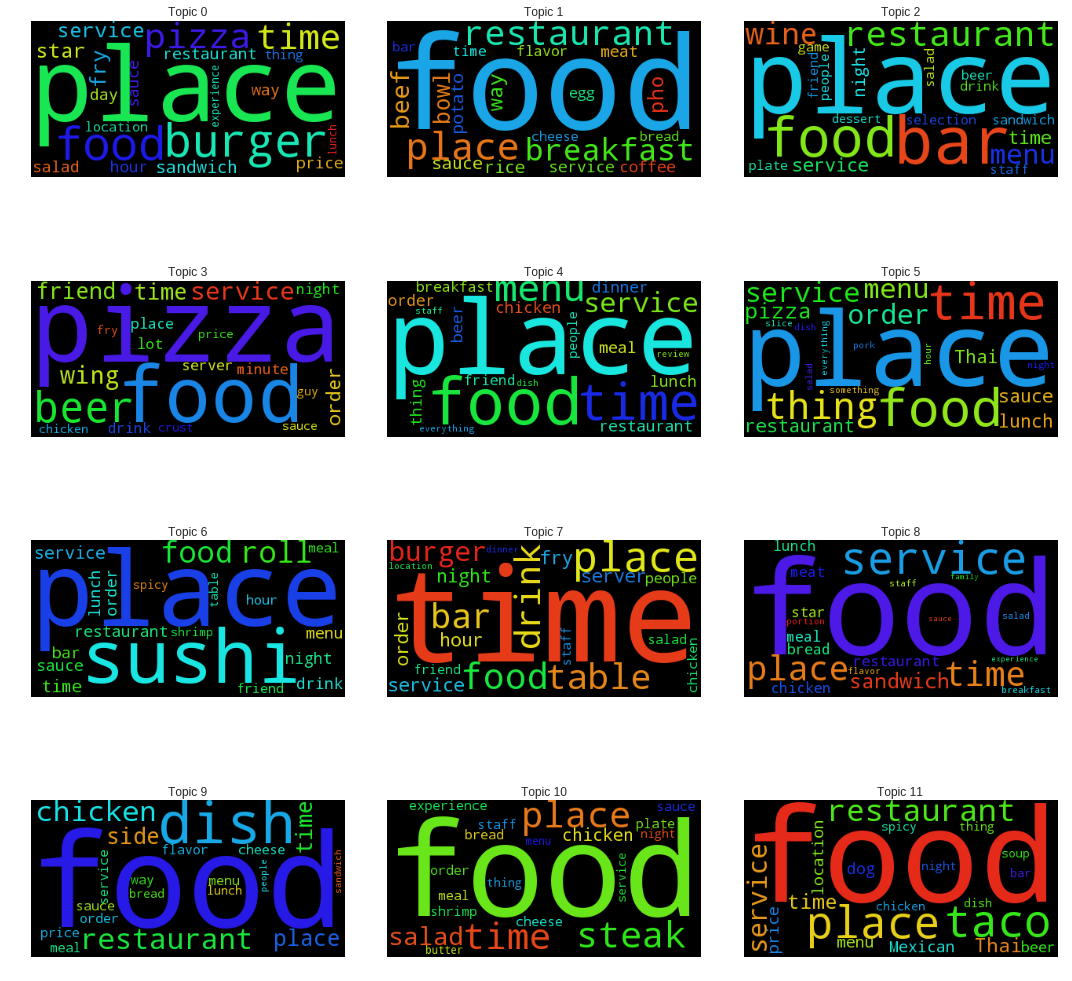

In [69]:
# wordcloud visualization of top 20 terms for each topic
from wordcloud import WordCloud

plt.figure()
f, ax = plt.subplots(4, 3, figsize=(15,15))
ax = ax.flatten()
    
for topic_id in range(NUM_TOPICS):
    term_probs = model.show_topic(topic_id, topn=20)
    freqs = []
    for prob, term in term_probs:
        freqs.append((term, prob))
    wc = WordCloud()
    elements = wc.fit_words(freqs)
    #plt.figure(figsize=(4, 4))
    #plt.imshow(wc)
    #plt.axis("off")
    #plt.show()
    ax[topic_id].imshow(wc)
    ax[topic_id].axis("off")
    #ax[i].show()
    ax[topic_id].set_title('Topic ' + str(topic_id))
    
plt.tight_layout()

In [70]:
# print the first positive yelp review
a_review = review_df[review_df['review_id'] == 'fWKvX83p0-ka4JS3dc6E5A']
a_review

,review_id,sentiment,stars,tagged_sentences,text,adjectives,word_counts,nouns
3,fWKvX83p0-ka4JS3dc6E5A,1,5,"[[(my, PRP$), (wife, NN), (took, VBD), (me, PR...",My wife took me here on my birthday for breakf...,"[excellent, perfect, absolute, excellent, semi...","{u'griddled': 1, u'bread': 1, u'meal': 1, u'an...","[wife, birthday, breakfast, weather, ground, p..."


In [71]:
a_review['nouns'][3]

[u'wife',
 u'birthday',
 u'breakfast',
 u'weather',
 u'ground',
 u'pleasure',
 u'waitress',
 u'food',
 u'Saturday',
 u'morning',
 u'place',
 u'favor',
 u'bloody',
 u'Mary',
 u'ingredient',
 u'garden',
 u'order',
 u'everything',
 u'menu',
 u'truffle',
 u'egg',
 u'skillet',
 u'piece',
 u'bread',
 u'toast']

### 6.2 Topic Visualization of one document

In [72]:
new_review_bow = dictionary.doc2bow(a_review['nouns'][3])
print(new_review_bow)

[(5, 1), (9, 1), (16, 1), (54, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)]


In [73]:
new_review_lda = model[new_review_bow]
print new_review_lda

[(4, 0.78688083753297078), (8, 0.18106672086164613)]


Original Author **Sujit Paul - Technology Research Director at Elsevier Labs**  
https://www.linkedin.com/in/sujitpal
http://sujitpal.blogspot.com/2015/07/using-keyword-generation-to-refine.html  
http://sujitpal.blogspot.com/2015/07/using-keyword-generation-to-refine.html

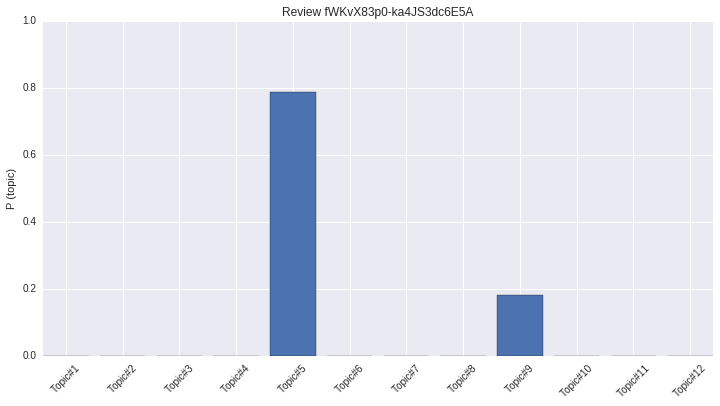

In [74]:
prob_dict = dict(new_review_lda)

ys = []
for i in range(NUM_TOPICS):    
    if prob_dict.has_key(i):
       ys.append(prob_dict[i])
    else:
        ys.append(0.0)
plt.figure(figsize=(12,6))
plt.title("Review %s" % ('fWKvX83p0-ka4JS3dc6E5A'))
plt.ylabel("P (topic)")
plt.ylim(0.0, 1.0)
plt.xticks(range(NUM_TOPICS), 
           ["Topic#%d" % (x + 1) for x in range(NUM_TOPICS)], rotation=45)
plt.grid(True)
plt.bar(range(NUM_TOPICS), ys, align="center")
plt.show()

### 6.3 Dynamic Visualisation of Topic Words using pyLDAvis

In [75]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      15.520496        1       1  0.002172 -0.021078
7      12.091145        1       2 -0.042861 -0.010958
0      10.063908        1       3 -0.052866 -0.036642
6       9.461013        1       4  0.030110  0.005640
5       9.022265        1       5 -0.001356 -0.016974
2       7.667327        1       6 -0.017238  0.002225
1       7.104522        1       7  0.091045  0.000498
9       6.824547        1       8  0.059836  0.003718
8       6.623116        1       9  0.031489 -0.037198
11      6.562633        1      10 -0.008738 -0.064994
3       4.916882        1      11 -0.136155  0.055402
10      4.142146        1      12  0.044562  0.120360, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
3057   Default   969.000000       pizza   969.000000  30.0000  30.0000
4500   Default  4428.000000        food  4428.000000  29.0000  29.0000
3013   Default   465.000000       sushi   465.000000  28.0000  28.0000
7339   Default   882.000000      burger   882.000000  27.0000  27.0000
4188   Default   470.000000        roll   470.000000  26.0000  26.0000
11253  Default   494.000000        taco   494.000000  25.0000  25.0000
9263   Default   673.000000        beer   673.000000  24.0000  24.0000
178    Default   221.000000        wing   221.000000  23.0000  23.0000
1172   Default   314.000000        Thai   314.000000  22.0000  22.0000
3941   Default   506.000000   breakfast   506.000000  21.0000  21.0000
478    Default   660.000000         fry   660.000000  20.0000  20.0000
3284   Default   318.000000       steak   318.000000  19.0000  19.0000
10325  Default   728.000000        dish   728.000000  18.0000  18.0000
281    Default  1971.000000     service  1971.000000  17.0000  17.0000
6151   Default  1003.000000         bar  1003.000000  16.0000  16.0000
4469   Default   149.000000         pho   149.000000  15.0000  15.0000
158    Default  4347.000000       place  4347.000000  14.0000  14.0000
314    Default   854.000000      friend   854.000000  13.0000  13.0000
180    Default   503.000000        wine   503.000000  12.0000  12.0000
5551   Default   290.000000      shrimp   290.000000  11.0000  11.0000
3102   Default   262.000000      coffee   262.000000  10.0000  10.0000
10098  Default   257.000000        bowl   257.000000   9.0000   9.0000
384    Default   484.000000        rice   484.000000   8.0000   8.0000
3842   Default   802.000000    sandwich   802.000000   7.0000   7.0000
11565  Default  1570.000000  restaurant  1570.000000   6.0000   6.0000
8297   Default  1080.000000     chicken  1080.000000   5.0000   5.0000
6102   Default   184.000000         dog   184.000000   4.0000   4.0000
3465   Default   937.000000       night   937.000000   3.0000   3.0000
1366   Default   735.000000        side   735.000000   2.0000   2.0000
1671   Default   938.000000       sauce   938.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
62     Topic12    14.589511        herb    41.707838   2.1336  -6.1964
732    Topic12   103.510003        time  2592.901570  -0.0369  -4.2370
158    Topic12   122.389658       place  4347.510432  -0.3862  -4.0695
5151   Topic12    56.315885       salad   927.101514   0.3829  -4.8457
1539   Topic12    48.826537  experience   692.530836   0.5319  -4.9884
3118   Topic12    40.921111       bread   539.572952   0.6048  -5.1651
387    Topic12    39.955132       plate   514.577701   0.6284  -5.1889
8394   Topic12    45.759077       staff   766.194692   0.3659  -5.0533
6741   Topic12    18.864625        rock    81.317640   1.7229  -5.9394
8297   Topic12    51.711152     chicken  1080.202791   0.1447  -4.9310
5970   Topic12    47.378507        meal   938.995463   0.1973  -5.0185
6788   Topic12    38.308399      cheese   553.443360   0.5135  -5.2310
2894  

Github does not render dynamic js UIs, so including screenshot

![alt text](images/pyldavis.png "pyldavis")